In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cleaning DataFrames

In [127]:
mistral_df = pd.read_csv('mistral.csv').drop(columns=["Additional Notes 1", "Additional Notes 2", "Additional Notes 3"])
ollama_df = pd.read_csv('ollama.csv').drop(columns=["User", "Additional Notes 1", "Additional Notes 2", "Additional Notes 3"])

# Plot 1

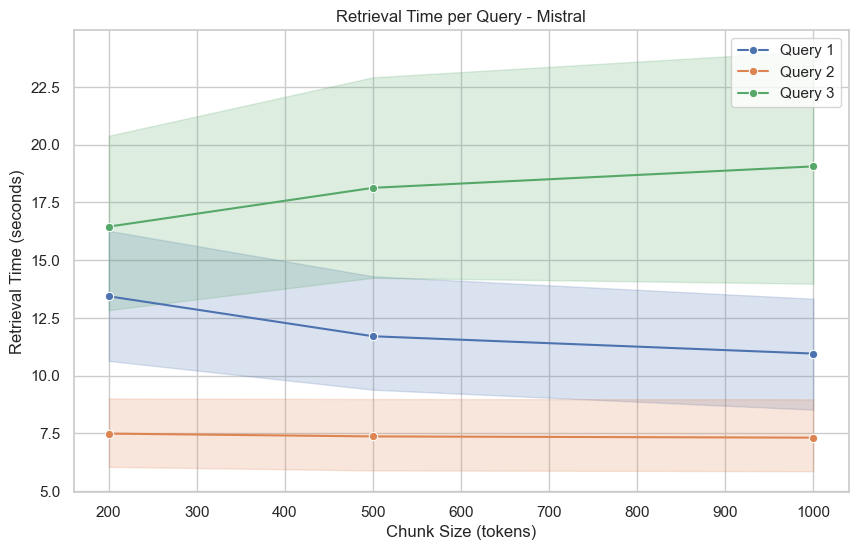

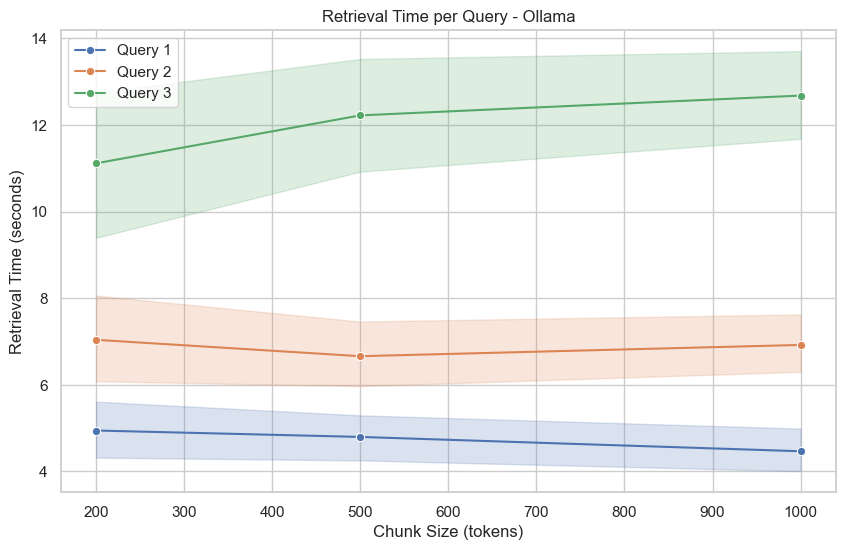

In [121]:
# Plot retrieval time per query
def plot_retrieval_time(df, model_name):
    plt.figure(figsize=(10, 6))

    redis_df = df[df['Vector Database'] == 'Redis']
    
    # Sort by chunk size
    df = df.sort_values(by="Chunk Size (tokens)")
    
    # Plot retrieval times for Query 1, Query 2, Query 3
    sns.lineplot(x=df["Chunk Size (tokens)"], y=df["Retrieval Quality (Query 1) (sec)"], label="Query 1", marker="o")
    sns.lineplot(x=df["Chunk Size (tokens)"], y=df["Retrieval Quality (Query 2) (sec)"], label="Query 2", marker="o")
    sns.lineplot(x=df["Chunk Size (tokens)"], y=df["Retrieval Quality (Query 3) (sec)"], label="Query 3", marker="o")
    
    plt.xlabel("Chunk Size (tokens)")
    plt.ylabel("Retrieval Time (seconds)")
    plt.title(f"Retrieval Time per Query - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_retrieval_time(mistral_df, "Mistral")
plot_retrieval_time(ollama_df, "Ollama")

# Plot 2

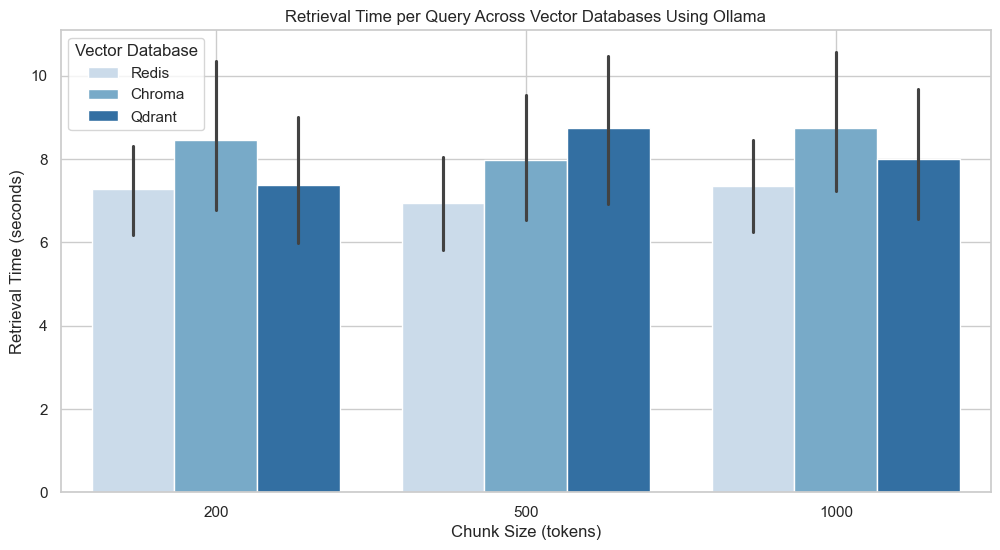

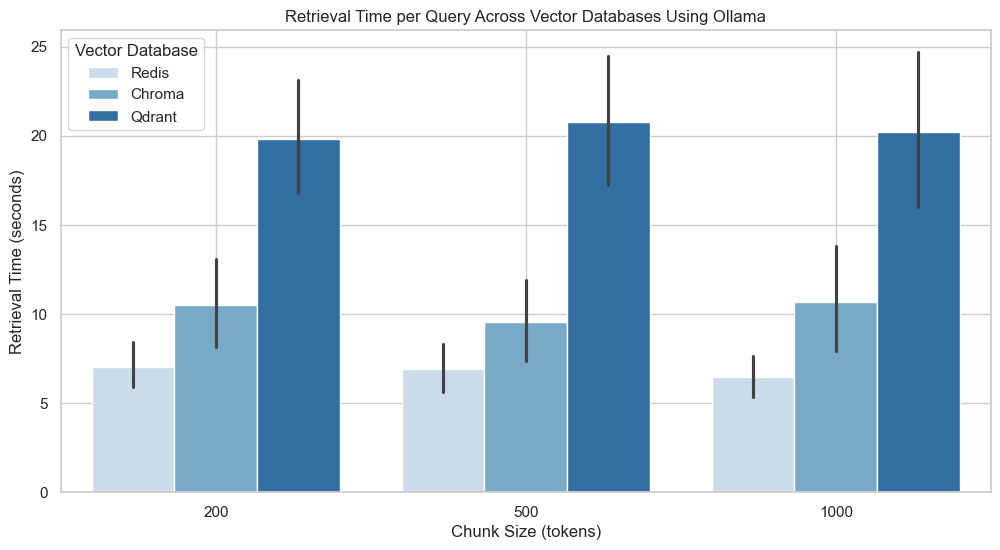

In [122]:
def retrieval_time_barplot(df):

    # Melt the df for Seaborn
    df_melted = df.melt(id_vars=["Chunk Size (tokens)", "Vector Database"], 
                        value_vars=["Retrieval Quality (Query 1) (sec)", 
                                    "Retrieval Quality (Query 2) (sec)", 
                                    "Retrieval Quality (Query 3) (sec)"],
                        var_name="Query", value_name="Retrieval Time")

    # Drop rows with missing retrieval times
    df_melted = df_melted.dropna()

    plt.figure(figsize=(12, 6))
    sns.barplot(x="Chunk Size (tokens)", y="Retrieval Time", hue="Vector Database", data=df_melted, palette='Blues')
    plt.xlabel("Chunk Size (tokens)")
    plt.ylabel("Retrieval Time (seconds)")
    plt.title("Retrieval Time per Query Across Vector Databases Using Ollama")
    plt.legend(title="Vector Database")
    plt.grid(True)
    plt.show()

retrieval_time_barplot(ollama_df)
retrieval_time_barplot(mistral_df)


# Plot 3

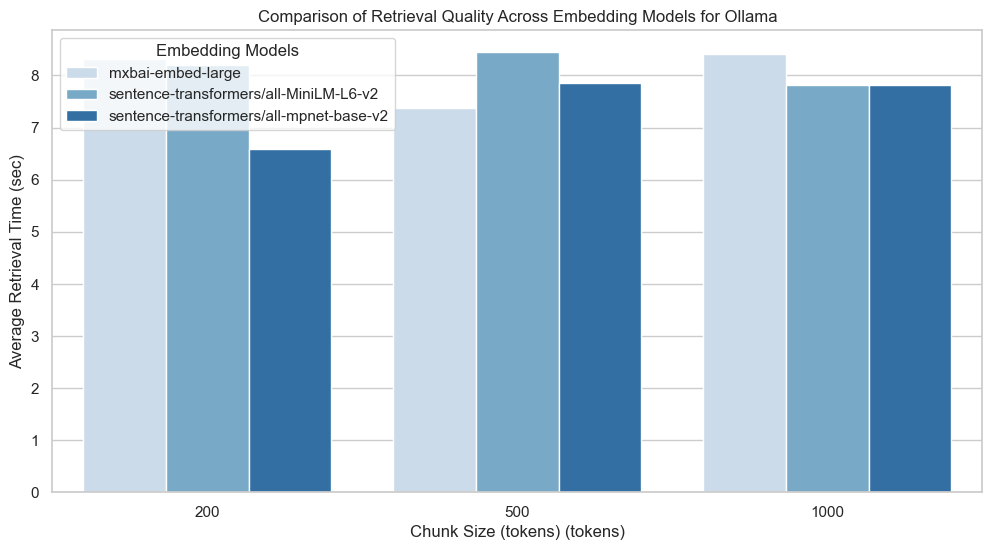

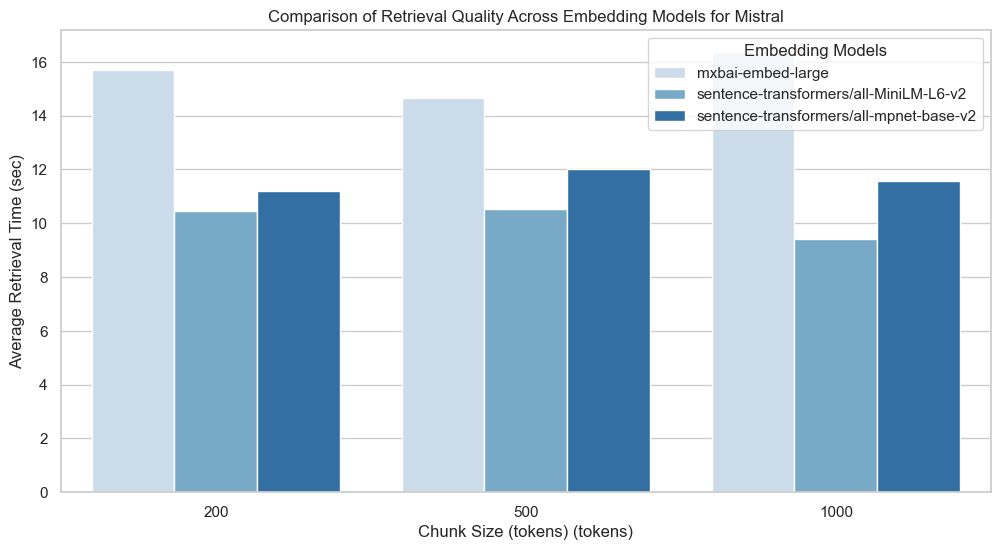

In [123]:
def plot_embedding_model_comparison(df, retrieval_cols, chunk_col, embedding_col, df_name):
    # Convert relevant columns to numeric
    df[retrieval_cols] = df[retrieval_cols].apply(pd.to_numeric, errors='coerce')

    # Compute average retrieval time across queries
    df['Avg Retrieval Time'] = df[retrieval_cols].mean(axis=1)

    # Group by chunk size and embedding model, then calculate the average retrieval time
    plot_data = df.groupby([chunk_col, embedding_col])['Avg Retrieval Time'].mean().reset_index()

    # Create the bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=plot_data, x=chunk_col, y='Avg Retrieval Time', hue=embedding_col, palette='Blues')

    # Titles and labels
    plt.title(f'Comparison of Retrieval Quality Across Embedding Models for {df_name}')
    plt.xlabel(f'{chunk_col} (tokens)')
    plt.ylabel('Average Retrieval Time (sec)')
    plt.legend(title=embedding_col)

    # Show plot
    plt.show()

plot_embedding_model_comparison(df=ollama_df, retrieval_cols=['Retrieval Quality (Query 1) (sec)', 'Retrieval Quality (Query 2) (sec)', 'Retrieval Quality (Query 3) (sec)'], chunk_col='Chunk Size (tokens)', embedding_col='Embedding Models', df_name='Ollama')
plot_embedding_model_comparison(df=mistral_df, retrieval_cols=['Retrieval Quality (Query 1) (sec)', 'Retrieval Quality (Query 2) (sec)', 'Retrieval Quality (Query 3) (sec)'], chunk_col='Chunk Size (tokens)', embedding_col='Embedding Models', df_name='Mistral')


# Plot 4

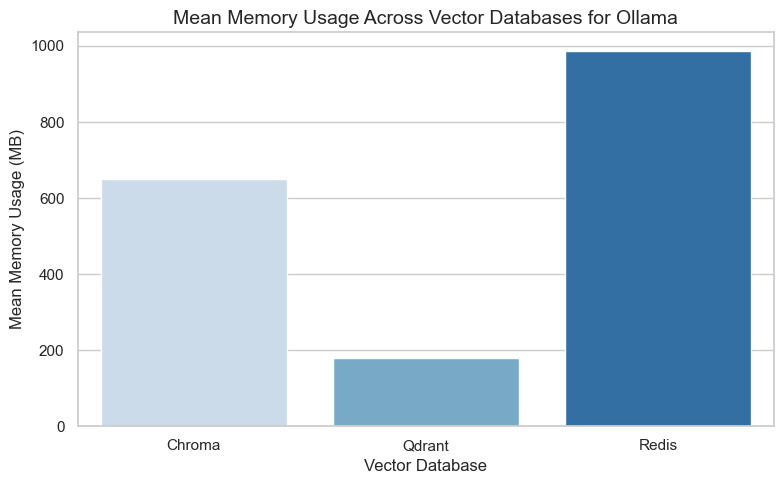

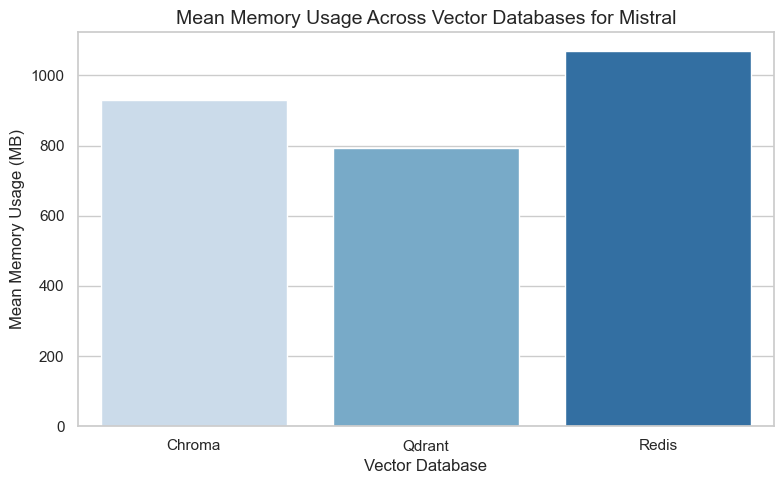

In [124]:
def compare_mean_memory_usage(data, df_name):
    
    # Calculate the mean of the memory usage columns for each vector database
    memory_columns = ['Memory Usage 1 (MB)', 'Memory Usage 2 (MB)', 'Memory Usage 3 (MB)']
    mean_memory_usage = data.groupby("Vector Database")[memory_columns].mean().reset_index()

    # Calculate the mean of these three columns for each vector database
    mean_memory_usage['Mean Memory Usage (MB)'] = mean_memory_usage[memory_columns].mean(axis=1)

    # Create a seaborn style plot
    sns.set(style="whitegrid")
    
    # Set up the figure
    plt.figure(figsize=(8, 5))
    
    # Create the plot
    sns.barplot(x="Vector Database", y="Mean Memory Usage (MB)", data=mean_memory_usage, palette="Blues", hue="Vector Database", legend=False)

    # Set labels and title
    plt.title(f"Mean Memory Usage Across Vector Databases for {df_name}", fontsize=14)
    plt.xlabel("Vector Database", fontsize=12)
    plt.ylabel("Mean Memory Usage (MB)", fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
compare_mean_memory_usage(ollama_df, "Ollama")
compare_mean_memory_usage(mistral_df, "Mistral")


## Plot 5

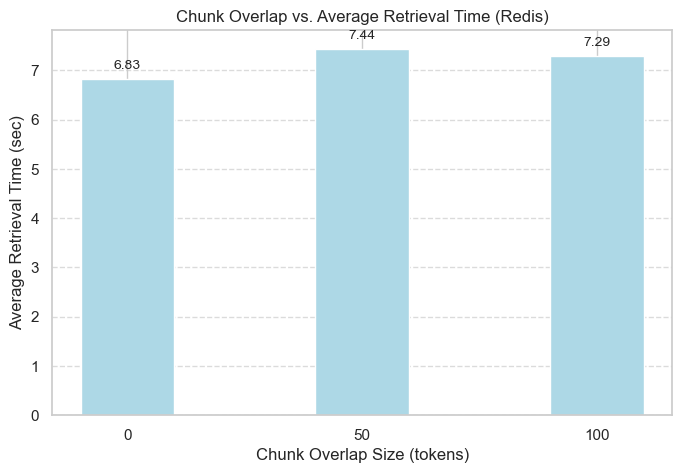

In [126]:
def plot_redis_retrieval_time(df):
    # Filter for Redis data
    redis_df = df[df["Vector Database"] == "Redis"]

    # Define the chunk overlap sizes
    chunk_overlap_sizes = [0, 50, 100]

    # Initialize list to store average retrieval times for each chunk overlap size
    avg_retrieval_times = []

    # Compute mean retrieval times for chunk overlaps 0, 50, and 100
    for overlap_size in chunk_overlap_sizes:
        overlap_df = redis_df[redis_df["Chunk Overlap Size (token overlap)"] == overlap_size]
        avg_time = overlap_df[["Retrieval Quality (Query 1) (sec)", 
                               "Retrieval Quality (Query 2) (sec)", 
                               "Retrieval Quality (Query 3) (sec)"]].mean(axis=1).mean()
        avg_retrieval_times.append(avg_time)

    # Create the bar plot
    plt.figure(figsize=(8, 5))
    plt.bar(chunk_overlap_sizes, avg_retrieval_times, color='lightblue', width=20)  
    plt.xlabel("Chunk Overlap Size (tokens)")
    plt.ylabel("Average Retrieval Time (sec)")
    plt.title("Chunk Overlap vs. Average Retrieval Time (Redis)")
    plt.xticks(chunk_overlap_sizes)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show values on bars
    for i, v in enumerate(avg_retrieval_times):
        plt.text(chunk_overlap_sizes[i], v + 0.2, f"{v:.2f}", ha='center', fontsize=10)

    plt.show()

plot_redis_retrieval_time(ollama_df)